In [2]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt

### Working with ROI Labels from Napari

In calcium imaging, we often define regions of interest (ROIs) spatially using labelled masks. These masks are typically stored as 2D arrays, where each pixel is assigned an integer label corresponding to a specific ROI. In this section, we load and inspect ROI labels that were previously drawn and exported from Napari. We will use these labelled masks as input for extracting average fluorescence signals from the movie. 

**Sub-sections:**

1. **Load the ROI label map from file**  
   Load the `roi.npy` file using NumPy and verify its shape and data type. This confirms that we have the correct 2D structure for ROI labels.

2. **Check and interpret unique ROI labels**  
   Use `np.unique()` to list all distinct ROI identifiers. This ensures that the mask contains the expected number of ROIs and uses a consistent labelling scheme.

3. **Visualize the label map as an image**  
   Display the ROI mask using a color map. This allows for a visual inspection of the labelled regions and confirms spatial correspondence with the field of view.

4. **Count the number of non-background ROIs**  
   Identify and count non-zero labels. This gives a concrete number of ROIs and ensures we exclude the background from future processing.


**Exercise** Load the ROI label map from file and confirm dimensions

In [3]:
movie = tiff.imread("data/registered_full_movie.tif")
movie.shape

(2000, 60, 80)

In [4]:
labels = np.load('data/roi.npy')
labels.shape

(60, 80)

**Exercise** Check and interpret unique ROI labels

In [5]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=uint8)

In [24]:
len(np.unique(labels)) - 1

15

**Exercise** Visualize the label map as an image

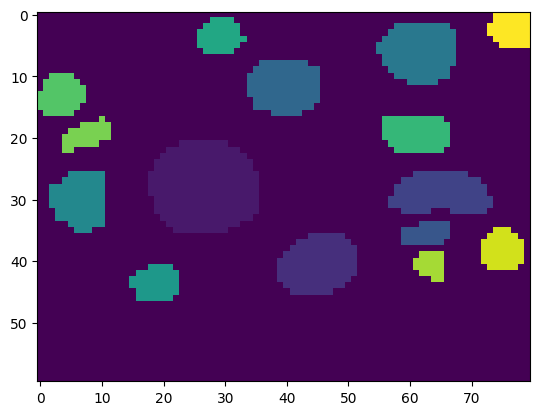

In [13]:
plt.imshow(labels)

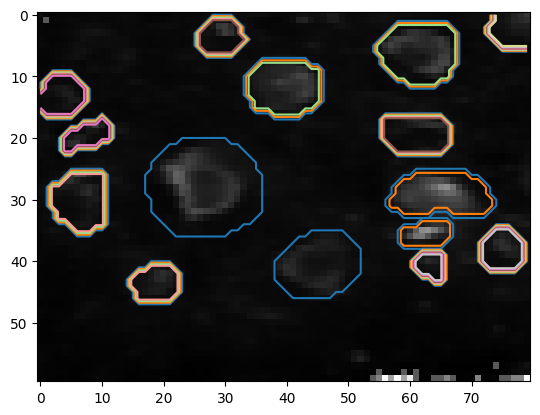

In [23]:
plt.imshow(movie.std(axis=0), cmap='gray')
plt.contour(labels, cmap='tab20')

### **Section 2 – From Label to Mask: Isolating ROI Pixels**

To extract a trace for a given ROI, we must first identify which pixels it occupies in the field of view. This section focuses on converting labelled ROI data into binary masks—arrays that define the spatial footprint of each individual neuron. Using these masks, we can isolate and examine raw pixel values belonging to each ROI. 

**Sub-sections:**

1. **Generate a boolean mask for a given ROI ID**  
   Use logical indexing to create a mask where pixels matching a specific ROI label are `True`. This mask selects the spatial extent of a single neuron.

2. **Apply the mask to a single movie frame**  
   Extract and display the ROI’s pixel values from one frame. This confirms the spatial accuracy of the mask against the actual image.

3. **Apply the mask across the full movie**  
   Use the same mask on the full movie (across time) to extract all values for a single ROI. This isolates the complete temporal profile of all ROI pixels.

4. **Compare multiple ROIs for consistency**  
   Repeat the above steps for several ROIs to ensure all are spatially distinct and extractable. This helps verify the consistency and utility of the labelled data.

**Exercise** Generate a boolean mask for a given ROI ID

Select an ROI ID from roi_ids (from Section 1), and create a binary mask that is True for pixels belonging to that ROI and False elsewhere.

In [25]:
mask = labels == 1
mask.sum()

np.int64(225)

In [26]:
mask = labels == 2
mask.sum()

np.int64(106)

In [27]:
mask = labels == 15
mask.sum()

np.int64(37)

**Exercise** Apply the mask to a single movie frame

Load a single frame from the calcium movie. Use the ROI mask to extract and visualize the pixel values from that frame.

In [31]:
frame = movie[0]
roi_pixels = frame[mask]
roi_pixels.size, roi_pixels.min(), roi_pixels.max(), roi_pixels.mean()

(37, np.float32(904.0), np.float32(2083.0), np.float32(1412.4595))

In [32]:
frame = movie[1]
roi_pixels = frame[mask]
roi_pixels.size, roi_pixels.min(), roi_pixels.max(), roi_pixels.mean()

(37, np.float32(640.0), np.float32(1902.0), np.float32(1263.7297))

In [33]:
frame = movie[1000]
roi_pixels = frame[mask]
roi_pixels.size, roi_pixels.min(), roi_pixels.max(), roi_pixels.mean()

(37, np.float32(1170.0), np.float32(2021.0), np.float32(1504.4054))

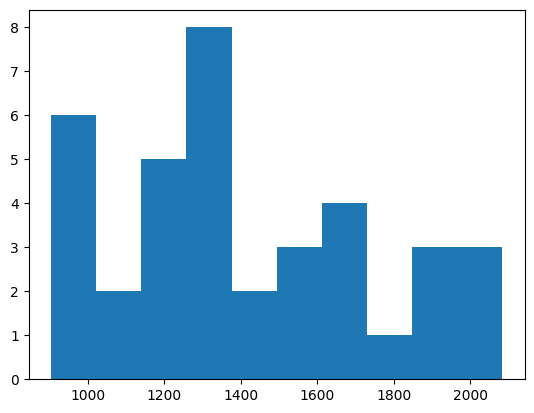

In [35]:
frame = movie[0]
roi_pixels = frame[mask]
plt.hist(roi_pixels);

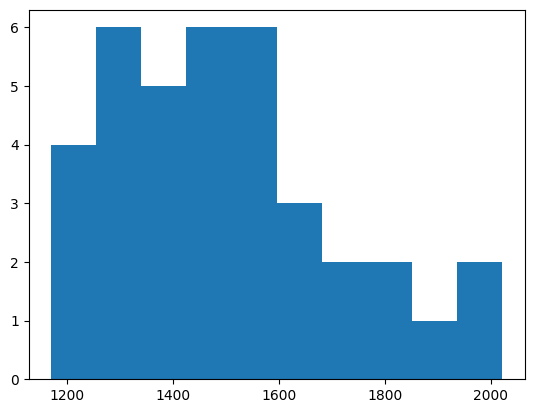

In [36]:
frame = movie[1000]
roi_pixels = frame[mask]
plt.hist(roi_pixels);

**Exercise** For a given ROI, apply the mask across the full movie

Extract pixel values from all frames in the movie for a given ROI. This should result in a 2D array of shape (T, N_pixels).

In [37]:
mask = labels == 1
roi_pixel_traces = movie[:, mask]
roi_pixel_traces.shape

(2000, 225)

### **Section 3 – Trace Extraction: Averaging ROI Pixels Over Time**

Having mapped each ROI to its set of pixels, we now use these spatial masks to extract the corresponding fluorescence traces. In this section, we compute the average signal across all ROI pixels at each timepoint. By repeating this process for every ROI, we generate a matrix of shape (N_ROIs, T) where each row represents the calcium activity of one neuron.

**Sub-sections:**

1. **Initialize the trace matrix**  
   Preallocate a matrix with shape `(n_rois, T)` where `T` is the number of frames. This defines the output format and ensures efficient storage.

2. **Loop over each ROI and extract its mask**  
   Iterate through ROI IDs and generate masks as in Section 2. This enables consistent ROI identification during extraction.

3. **Extract and average fluorescence for each ROI**  
   For each ROI, extract pixel values across time and compute the mean per frame. This produces a 1D fluorescence trace for each neuron.

4. **Store each trace in the trace matrix**  
   Populate the trace matrix with each averaged trace. This results in a structured 2D array where rows correspond to neurons and columns to timepoints.

### **Section 4 – Interpreting and Visualizing Extracted Traces**

With the trace matrix in hand, we turn to visualization and exploration. This section introduces simple plotting tools to inspect both individual traces and full populations of neurons. Visualization helps verify the success of the extraction process, and also offers a first glimpse into the temporal structure of the data. 

**Sub-sections:**

1. **Plot the full trace matrix across time**  
   Display all ROI traces using line plots. This helps verify the temporal dynamics and range of signals extracted.

2. **Inspect individual traces of selected ROIs**  
   Zoom into single-neuron traces. This provides a closer view of signal quality and variability within each ROI.

3. **Quantify trace statistics such as variance or mean**  
   Compute simple metrics such as standard deviation or maximum value. These provide insights into neuron activity levels and signal-to-noise ratios.

4. **Filter or annotate traces based on properties**  
   Tag ROIs as active or inactive based on thresholds. This sets the stage for further preprocessing or selection of neurons for downstream analysis.